## 1.Import Libraries

In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
import tensorflow.keras as keras
import cv2 as cv
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
print(tf.__version__)

2.3.2


In [20]:
# from tensorflow.python.client import device_lib

# print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10526234722557886678
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 413953203300421183
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4951408640
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5816098574039315886
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4358895157483221350
physical_device_desc: "device: XLA_GPU device"
]


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## 2. Get Dataset

In [3]:
heatmap_ds_spec = (tf.TensorSpec(shape=(None, None, 3), dtype = tf.float32, name = None),
                   tf.TensorSpec(shape=(None, None, 17), dtype = tf.float32, name = None),
                   tf.TensorSpec(shape=(None, None, 17), dtype = tf.float32, name = None))

output_path = 'C:/Users/jorge/Documents/Python/Intento PoseEstimation/Datasets/Players_Phase1/heatmaps/20230623'
heatmap_dataset = tf.data.experimental.load(path = output_path, element_spec=heatmap_ds_spec)


In [4]:
pafs_ds_spec = (tf.TensorSpec(shape=(None, None, 3), dtype = tf.float32, name = None),
                tf.TensorSpec(shape=(None, None, 34), dtype = tf.float32, name = None),
                tf.TensorSpec(shape=(None, None, 34), dtype = tf.float32, name = None))

output_path = 'C:/Users/jorge/Documents/Python/Intento PoseEstimation/Datasets/Players_Phase1/pafs/20230623'
paf_dataset = tf.data.experimental.load(path = output_path, element_spec=pafs_ds_spec)

In [5]:
combined_dataset = tf.data.Dataset.zip((heatmap_dataset, paf_dataset))

def clean_ds(heatmap_ds, paf_ds):
    
    image = heatmap_ds[0]
    heatmap = heatmap_ds[1]
    heatmap_mask = heatmap_ds[2]
    paf = paf_ds[1]
    paf_mask = paf_ds[2]

    image = tf.keras.applications.vgg19.preprocess_input(image)    

    #heatmap = tf.stack([heatmap, heatmap_mask])
    #paf = tf.stack([paf, paf_mask])
    # labels = {'paf_stage0' : paf, 'paf_stage1' : paf, 'paf_stage2' : paf, 'paf_stage3' : paf,
    #           'heatmap_stage0' : heatmap, 'heatmap_stage1' : heatmap, 'heatmap_stage2' : heatmap, 'heatmap_stage3' : heatmap}
    # labels = {'paf_stage0' : paf}

    labels = {'paf_stage0' : paf, 'paf_stage1' : paf}

    return image, labels

combined_dataset = combined_dataset.map(clean_ds).batch(3).prefetch(1)

## 3. Get Keras Backbone

#### 3.1 VGG Backbone

In [6]:
# Download the keras backbone
keras_model = keras.applications.VGG19(weights='imagenet', include_top = False, input_shape = (224,224,3))
keras_model.trainable = False
keras_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
input_layer = keras_model.layers[0]
n = 0
for layer in keras_model.layers[1:]:
    if n == 0:
        x = layer(input_layer.output)
    elif n == 9:
        break
    else:
        x = layer(x)
    n += 1

backbone_model = keras.models.Model(inputs = input_layer.input, outputs = x, name = 'Backbone')
backbone_output = x
backbone_model.summary()    

Model: "Backbone"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

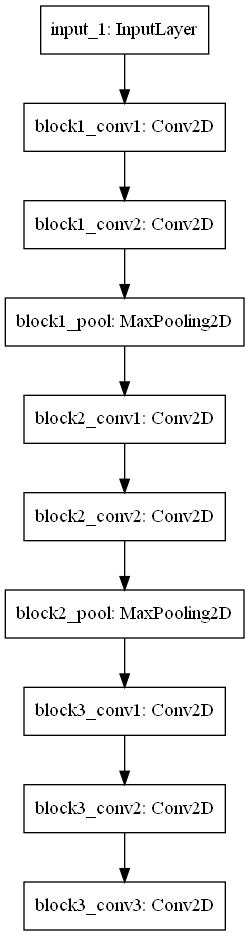

In [8]:
keras.utils.plot_model(backbone_model)

In [9]:
backbone_output

<tf.Tensor 'block3_conv3/Relu_1:0' shape=(None, 56, 56, 256) dtype=float32>

## 4. Define Stage Functions

In [6]:
def convolution_block(x, n_filters, name):

    first_layer = keras.layers.Conv2D(filters = n_filters, kernel_size = (3,3), strides = 1, padding = 'same', name = 'first_conv_layer_of_' + name)(x)
    # first_layer = keras.layers.Activation('relu')(first_layer)
    first_layer = keras.layers.PReLU()(first_layer)
    second_layer = keras.layers.Conv2D(filters = n_filters, kernel_size = (3,3), strides = 1, padding = 'same', name = 'second_conv_layer_of_' + name)(first_layer)
    # second_layer = keras.layers.Activation('relu')(second_layer)
    second_layer = keras.layers.PReLU()(second_layer)
    third_layer = keras.layers.Conv2D(filters = n_filters, kernel_size = (3,3), strides = 1, padding = 'same', name = 'third_conv_layer_of_' + name)(second_layer)
    # third_layer = keras.layers.Activation('relu')(third_layer)
    third_layer = keras.layers.PReLU()(third_layer)
    result = keras.layers.concatenate([first_layer, second_layer, third_layer], name = 'concat_layer_of_' + name)

    return result

def make_paf_stages(inputs, n_outputs, n_filters_for_conv_block, n_filters_k1, name):

    if 'stage0' in name:
        inputs = inputs
    else:
        backbone_output = keras.layers.UpSampling2D(size=(4, 4))(inputs[0])
        inputs = [backbone_output, inputs[1]]
        inputs = keras.layers.concatenate(inputs)

    x = convolution_block(inputs, n_filters = n_filters_for_conv_block, name = name + '_first_conv_block_')
    x = keras.layers.BatchNormalization(axis = -1)(x)
    x = convolution_block(x, n_filters = n_filters_for_conv_block, name = name + '_second_conv_block_')
    x = convolution_block(x, n_filters = n_filters_for_conv_block, name = name + '_third_conv_block_')
    x = convolution_block(x, n_filters = n_filters_for_conv_block, name = name + '_forth_conv_block_')
    x = convolution_block(x, n_filters = n_filters_for_conv_block, name = name + '_fifth_conv_block_')
    x = keras.layers.BatchNormalization(axis = -1)(x)
    x = keras.layers.Conv2D(filters = n_filters_k1, kernel_size = (1,1), strides = 1, padding = 'same')(x)
    # x = keras.layers.Activation('relu')(x)
    x = keras.layers.PReLU()(x)
    x = keras.layers.Conv2D(filters = n_outputs, kernel_size = (1,1), strides = 1, padding = 'same')(x)

    if 'stage0' in name:
        # x = keras.layers.Activation('sigmoid' if n_outputs == 17 else 'tanh')(x)
        x = keras.layers.PReLU()(x)
        x = keras.layers.UpSampling2D(size=(4, 4), name = name)(x)
    else:
        # x = keras.layers.Activation('sigmoid' if n_outputs == 17 else 'tanh', name = name)(x)
        x = keras.layers.PReLU(name = name)(x)

    return x

def make_heatmap_stages(inputs, n_outputs, n_filters_for_conv_block, n_filters_k1, name):

    backbone_output = keras.layers.UpSampling2D(size=(4, 4))(inputs[0])
    if 'stage0' in name:
        inputs = [backbone_output, inputs[1]]
    else:
        inputs = [backbone_output, inputs[1], inputs[2]]

    inputs = keras.layers.concatenate(inputs)

    x = convolution_block(inputs, n_filters = n_filters_for_conv_block)
    x = keras.layers.BatchNormalization(axis = -1)(x)
    x = convolution_block(x, n_filters = n_filters_for_conv_block)
    x = convolution_block(x, n_filters = n_filters_for_conv_block)
    x = convolution_block(x, n_filters = n_filters_for_conv_block)
    x = convolution_block(x, n_filters = n_filters_for_conv_block)
    x = keras.layers.BatchNormalization(axis = -1)(x)
    x = keras.layers.Conv2D(filters = n_filters_k1, kernel_size = (1,1), strides = 1, padding = 'same')(x)
    # x = keras.layers.Activation('relu')(x)
    x = keras.layers.PReLU()(x)
    x = keras.layers.Conv2D(filters = n_outputs, kernel_size = (1,1), strides = 1, padding = 'same')(x)
    x = keras.layers.Activation('sigmoid' if n_outputs == 17 else 'tanh', name=name)(x)

    return x

In [36]:
stage0_paf = make_paf_stages(inputs = backbone_output, n_outputs = 34, n_filters_for_conv_block = 96, n_filters_k1 = 256, name = 'paf_stage0')
# stage1_paf = make_paf_stages(inputs = [backbone_output, stage0_paf], n_outputs = 34, n_filters_for_conv_block = 128, n_filters_k1 = 512, name = 'paf_stage1')
# stage2_paf = make_paf_stages(inputs = [backbone_output, stage1_paf], n_outputs = 34, n_filters_for_conv_block = 128, n_filters_k1 = 512, name = 'paf_stage2')
# stage3_paf = make_paf_stages(inputs = [backbone_output, stage2_paf], n_outputs = 34, n_filters_for_conv_block = 128, n_filters_k1 = 512, name = 'paf_stage3')

# stage0_heatmap = make_heatmap_stages(inputs = [backbone_output, stage3_paf], n_outputs = 17, n_filters_for_conv_block = 96, n_filters_k1 = 256, name = 'heatmap_stage0')
# stage1_heatmap = make_heatmap_stages(inputs = [backbone_output, stage3_paf, stage0_heatmap], n_outputs = 17, n_filters_for_conv_block = 128, n_filters_k1 = 512, name = 'heatmap_stage1')
# stage2_heatmap = make_heatmap_stages(inputs = [backbone_output, stage3_paf, stage1_heatmap], n_outputs = 17, n_filters_for_conv_block = 128, n_filters_k1 = 512, name = 'heatmap_stage2')
# stage3_heatmap = make_heatmap_stages(inputs = [backbone_output, stage3_paf, stage2_heatmap], n_outputs = 17, n_filters_for_conv_block = 128, n_filters_k1 = 512, name = 'heatmap_stage3')

## 5.Build Model

In [23]:
# outputs = [stage0_paf, stage1_paf, stage2_paf, stage3_paf,
#            stage0_heatmap, stage1_heatmap, stage2_heatmap, stage3_heatmap]
outputs = [stage0_paf]
model = keras.models.Model(inputs = input_layer.input, outputs = outputs, name = 'Final_Model')

In [ ]:
model.summary()

In [33]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)

In [ ]:
# This function has not been tested yet
def test_loss_combined(y_true, y_pred):
    mask = y_true[:,1]
    delta = tf.square(y_true[:,0] - y_pred)
    return delta*mask

In [29]:
# This function has not been tested yet
def heatmap_custom_metric(y_true, y_pred):
    # Extract the three tensors
    image, heatmap, heatmap_mask, paf, paf_mask = y_true
    ssim = tf.image.ssim(heatmap, y_pred, max_val=1.0)
    mean_ssim = tf.reduce_mean(ssim)
    return mean_ssim

In [30]:
# This function has not been tested yet
def paf_custom_metric(y_true, y_pred):
    # Extract the three tensors
    image, heatmap, heatmap_mask, paf, paf_mask = y_true
    cos_sim = tf.keras.metrics.CosineSimilarity(axis=-1)
    cos_sim_value = cos_sim(paf, y_pred)
    return cos_sim_value

In [26]:
model.compile(loss='mse', optimizer = optimizer)
# keras.utils.plot_model(model)
# model.summary()

In [22]:
amount_bytes = 0
for layer in model.layers:
    if len(layer.output_shape) == 1:
        amount = layer.output_shape[0][1]*layer.output_shape[0][2]*layer.output_shape[0][3]*4
    else:
        amount = layer.output_shape[1]*layer.output_shape[2]*layer.output_shape[3]*4
    amount_bytes += amount
    # print(amount)
print(f'amount in bytes is : {amount_bytes}, the amount in mb is : {amount_bytes/(1024*1024)}, the amount in gb is : {amount_bytes/(1024*1024*1024)}')

amount in bytes is : 1768051712, the amount in mb is : 1686.1455078125, the amount in gb is : 1.6466264724731445


In [18]:
model.fit(combined_dataset, epochs = 200)

Epoch 1/200
2/2 [==============================] - 0s 32ms/step - loss: 9.9436e-04
Epoch 2/200
2/2 [==============================] - 0s 92ms/step - loss: 9.9101e-04
Epoch 3/200
2/2 [==============================] - 0s 91ms/step - loss: 9.7906e-04
Epoch 4/200
2/2 [==============================] - 0s 86ms/step - loss: 9.7924e-04
Epoch 5/200
2/2 [==============================] - 0s 73ms/step - loss: 9.7050e-04
Epoch 6/200
2/2 [==============================] - 0s 89ms/step - loss: 9.6756e-04
Epoch 7/200
2/2 [==============================] - 0s 73ms/step - loss: 9.5835e-04
Epoch 8/200
2/2 [==============================] - 0s 83ms/step - loss: 9.5417e-04
Epoch 9/200
2/2 [==============================] - 0s 77ms/step - loss: 9.4887e-04
Epoch 10/200
2/2 [==============================] - 0s 73ms/step - loss: 9.4357e-04
Epoch 11/200
2/2 [==============================] - 0s 75ms/step - loss: 9.3808e-04
Epoch 12/200
2/2 [==============================] - 0s 78ms/step - loss: 9.3332e-04
E

In [29]:
output_model_path = 'C:/Users/jorge/Documents/Python/Intento PoseEstimation/models/stage_0_paf_model.keras'
model.save(output_model_path)

In [7]:
output_model_path = 'C:/Users/jorge/Documents/Python/Intento PoseEstimation/models/stage_0_paf_model.keras'
model = tf.keras.models.load_model(output_model_path)

In [8]:
for layer in model.layers:
    layer.trainable = False

In [13]:
backbone_output

<tf.Tensor 'block3_conv3/Relu_1:0' shape=(None, 56, 56, 256) dtype=float32>

In [9]:
for layer in model.layers:
    print(layer.output.name)

input_1:0
block1_conv1/Relu:0
block1_conv2/Relu:0
block1_pool/MaxPool:0
block2_conv1/Relu:0
block2_conv2/Relu:0
block2_pool/MaxPool:0
block3_conv1/Relu:0
block3_conv2/Relu:0
block3_conv3/Relu:0
first_conv_layer_of_paf_stage0_first_conv_block_/BiasAdd:0
p_re_lu_52/add:0
second_conv_layer_of_paf_stage0_first_conv_block_/BiasAdd:0
p_re_lu_53/add:0
third_conv_layer_of_paf_stage0_first_conv_block_/BiasAdd:0
p_re_lu_54/add:0
concat_layer_of_paf_stage0_first_conv_block_/concat:0
batch_normalization_6/cond/Identity:0
first_conv_layer_of_paf_stage0_second_conv_block_/BiasAdd:0
p_re_lu_55/add:0
second_conv_layer_of_paf_stage0_second_conv_block_/BiasAdd:0
p_re_lu_56/add:0
third_conv_layer_of_paf_stage0_second_conv_block_/BiasAdd:0
p_re_lu_57/add:0
concat_layer_of_paf_stage0_second_conv_block_/concat:0
first_conv_layer_of_paf_stage0_third_conv_block_/BiasAdd:0
p_re_lu_58/add:0
second_conv_layer_of_paf_stage0_third_conv_block_/BiasAdd:0
p_re_lu_59/add:0
third_conv_layer_of_paf_stage0_third_conv_blo

In [10]:
for layer in model.layers:
    if layer.output.name == 'block3_conv3/Relu:0':
        backbone_output = layer.output
    elif layer.output.name == 'paf_stage0/resize/ResizeNearestNeighbor:0':
        stage0_paf = layer.output
    # print(layer.output.name)

print(backbone_output)
print(stage0_paf)

Tensor("block3_conv3/Relu:0", shape=(None, 56, 56, 256), dtype=float32)
Tensor("paf_stage0/resize/ResizeNearestNeighbor:0", shape=(None, 224, 224, 34), dtype=float32)


In [44]:
stage0_paf

<tf.Tensor 'paf_stage0/resize/ResizeNearestNeighbor:0' shape=(None, 224, 224, 34) dtype=float32>

In [11]:
stage1_paf = make_paf_stages(inputs = [backbone_output, stage0_paf], n_outputs = 34, n_filters_for_conv_block = 128, n_filters_k1 = 512, name = 'paf_stage1')

In [12]:
input_layer = model.layers[0]
outputs = [stage0_paf, stage1_paf]
model = keras.models.Model(inputs = input_layer.input, outputs = outputs, name = 'Final_Model')

In [13]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule)

In [14]:
model.compile(loss='mse', optimizer = optimizer)

In [15]:
model.fit(combined_dataset, epochs = 200)

Epoch 1/200


ResourceExhaustedError:  OOM when allocating tensor with shape[3,224,224,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node Final_Model/p_re_lu_8/Relu_1-0-0-TransposeNCHWToNHWC-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_8434]

Function call stack:
train_function


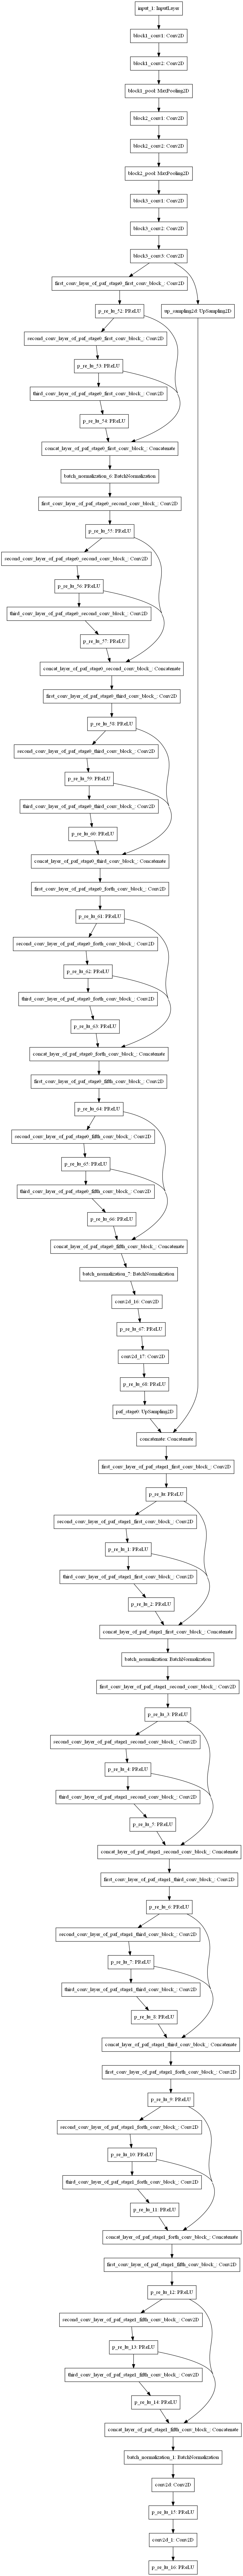

In [24]:
keras.utils.plot_model(model)

# 6. Extra Functions

In [12]:
class Masked_Mean_Squared_Error_Loss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def call(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        y_true = y_true[...]
        mask = y_true[...]
        mask = 1
        error = y_true - y_pred
        error = tf.square(error)
        error = tf.reduce_mean(error, axis = -1)
        loss = tf.math.multiply(mask, error)
        
        return loss


In [13]:
layer_names = get_layer_names()
losses = {}
for layer in layer_names:
    losses[layer] = 'categorical_crossentropy'
losses

NameError: name 'get_layer_names' is not defined

In [ ]:
print(type(keras_model.layers[2]))
print()
print(keras_model.layers[2].get_config())
print()
print(keras_model.layers[2].get_weights())

In [51]:
weights = keras_model.layers[2].get_weights()[0]
weights = weights[0,0,:,:]

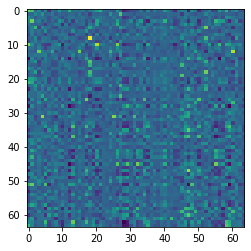

In [52]:
plt.imshow(weights)

In [32]:
for i in combined_dataset:
  image = i[0]
  break

In [62]:
predictions = model.predict(image)

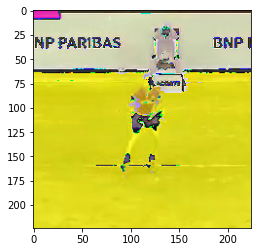

In [45]:
plt.imshow(image[0].numpy().astype(np.uint8))

In [53]:
for i in heatmap_dataset:
  real_image = i[0]
  real_heatmap = i[1]
  break

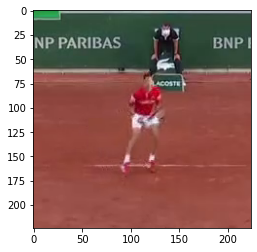

In [54]:
plt.imshow(real_image.numpy().astype(np.uint8))

In [63]:
paf_prediction = predictions[0]
type(paf_prediction)

numpy.ndarray

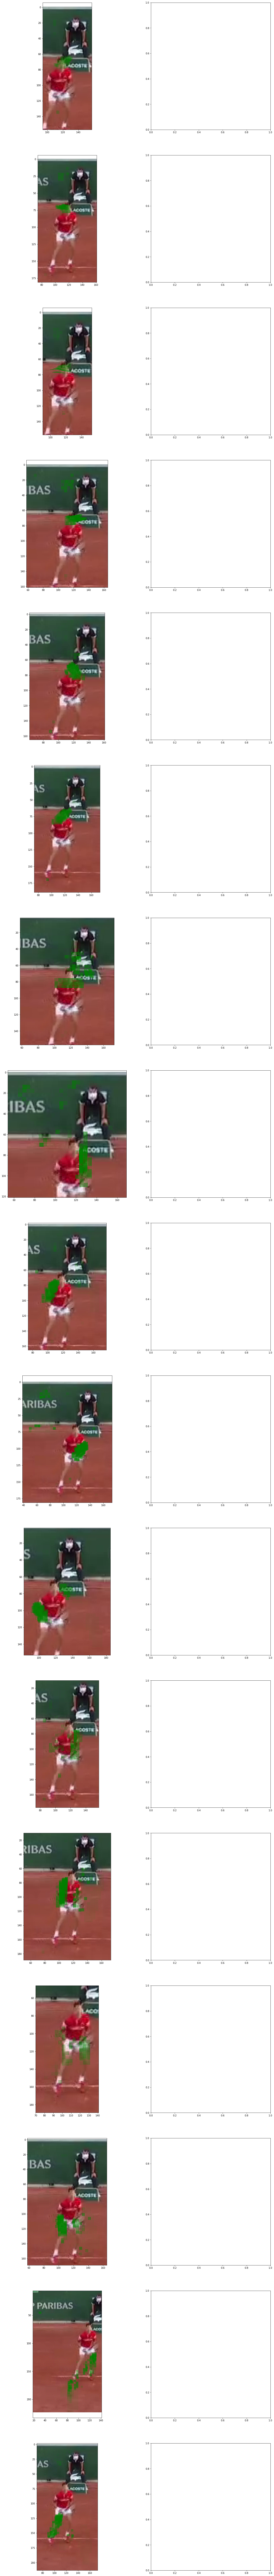

In [64]:
# This is the last function to plot the crop pafs
ncols = 2
nrows = 17

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,200), sharey=False)
all_axes = axes.flatten()
n = 0
C = 'g'


non_zero_indices = tf.where(paf_prediction != 0)[:,2]
for x in range(nrows):
      axes[x,0].imshow(real_image.numpy().astype(np.uint8))
      first_index = x*2
      second_index = first_index + 1
      index_filt = non_zero_indices == first_index
      index_filt2 = non_zero_indices == second_index
      if tf.greater_equal(tf.reduce_sum(tf.cast(index_filt, dtype = tf.float32)), tf.reduce_sum(tf.cast(index_filt2, dtype = tf.float32))):
          index_filt = index_filt
      else:
          index_filt = index_filt2

      X = tf.where(paf_prediction != 0)[index_filt][:,1].numpy()
      Y = tf.where(paf_prediction != 0)[index_filt][:,0].numpy()

      U_flatten_filter = tf.reshape(paf_prediction[:,:,first_index] != 0, [-1])
      V_flatten_filter = tf.reshape(paf_prediction[:,:,second_index] != 0, [-1])
      if tf.greater_equal(tf.reduce_sum(tf.cast(V_flatten_filter, dtype = tf.float32)), tf.reduce_sum(tf.cast(U_flatten_filter, dtype = tf.float32))):
          flatten_filter = V_flatten_filter
      else:
          flatten_filter = U_flatten_filter

      V_flatten_array = tf.reshape(paf_prediction[:,:,second_index], [-1])
      V = V_flatten_array[flatten_filter].numpy()*(-1)


      U_flatten_array = tf.reshape(paf_prediction[:,:,first_index], [-1])
      U = U_flatten_array[flatten_filter].numpy()

      axes[x,0].quiver(X, Y, U, V, color = C, linewidths = 0.05)
      if len(X) == 0:
          x1 = 0
          x2 = 224
          y1 = 0
          y2 = 224
      else:
          x1 = np.min(X) - 10
          x2 = np.max(X) + 10
          y1 = np.min(Y) - 10
          y2 = np.max(Y) + 10
      axes[x,0].set_xlim(x1, x2)
      axes[x,0].set_ylim(y2, y1)

      # title = list(paf_dict.keys())[x]
      # axes[x,0].set_title(title, fontsize = 18)


      # axes[x,1].imshow(tf.cast(i[2][:,:,first_index], dtype = tf.uint8).numpy())
      # mask_values = '-'.join(str(e) for e in list(np.unique(i[2][:,:,first_index].numpy())))
      # axes[x,1].text(112.0, 245.0, mask_values, ha="center", fontsize=18, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
